### В этой работе:
1. Скачаем [датасет](https://www.manythings.org/anki/rus-eng.zip) англо-русскую пару фраз
2. Обучим seq2seq модель with attention
* На основе скалярного произведения
* На основе MLP
Оцените качество
3. Оценим качество модели

### Загрузим данные

In [30]:
%matplotlib inline

In [31]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# загрузим данные
# !wget https://www.manythings.org/anki/rus-eng.zip

In [4]:
# # распакуем
# import zipfile

# with zipfile.ZipFile(r"D:\Progect\RNN\rus-eng.zip", 'r') as zip_ref:
#     zip_ref.extractall("D:\Progect\RNN")

In [5]:
# смотрим что внутри, выведем последние 10 строк текста
with open(r"/content/eng-rus.txt", 'r') as file:
    lines = file.readlines()
    for line in lines[-10:]:  # Shows last 10 lines
        print(line.strip())

We need to uphold laws against discrimination — in hiring, and in housing, and in education, and in the criminal justice system. That is what our Constitution and our highest ideals require.	Нам нужно отстаивать законы против дискриминации при найме на работу, в жилищной сфере, в сфере образования и правоохранительной системе. Этого требуют наша Конституция и высшие идеалы.	CC-BY 2.0 (France) Attribution: tatoeba.org #5762728 (BHO) & #6390439 (odexed)
I've heard that you should never date anyone who is less than half your age plus seven. Tom is now 30 years old and Mary is 17. How many years will Tom need to wait until he can start dating Mary?	Я слышал, что никогда не следует встречаться с кем-то вдвое младше вас плюс семь лет. Тому 30 лет, a Мэри 17. Сколько лет Тому нужно ждать до тех пор, пока он сможет начать встречаться с Мэри?	CC-BY 2.0 (France) Attribution: tatoeba.org #10068197 (CK) & #10644473 (notenoughsun)
I do have one final ask of you as your president, the same thing I a

### Выполним предварительную обработку данных

In [6]:
SOS_token = 0   # Start of sequence
EOS_token = 1   # End of sequence

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [7]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427

# преобразуем символы Unicode в ASCII, сделаем все строчными и удалим большую часть знаков препинания
# удалим диакритические знаки
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'  # проверяем, что категория символа c не является "Mn" (Mark, Nonspacing), то есть это не диакритический знак.
    )

# проведем предобработку текста
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    # s = re.sub(r"[^а-яА-Я.!?]+", r" ", s)
    return s

In [8]:
# прочитаем текст с парами предложений
# флаг reverse, указывает нужно ли поменять язык перевода местами
# если  reverse=True - меняем порядок предложений в каждой паре
# если reverse=False - оставляем порядок предложений без изменений
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Прочитаем текст построчно
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # разделитель в тексте разный, в моем случаее это CC-BY
    lines = [i.split('\tCC-BY', 1)[0] for i in lines]

    # Соеденим каждую строку в пару предложений, проведем нормализацию текста
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Возвращаем список пар слов
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [9]:
# максимальное количество слов в предложении
MAX_LENGTH = 20

# Префиксы для предложений
ENGLISH_PREFIXES = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(ENGLISH_PREFIXES)

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

Полный процесс подготовки данных выглядит следующим образом:
* Прочитать текстовый файл и разбить его на строки, разбить строки на пары
* Нормализовать текст, отфильтровать по длине и содержанию
* Составьте списки слов из предложений в парах.

In [10]:
# функция подготовки данных для машинного перевода
# lang1 и lang2 - коды языков (например, 'eng' для английского, 'rus' для русского)
# reverse=False - направление перевода
def prepareData(lang1, lang2, reverse=False):

    # выведим количество прочитанных пар предложений
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))

    # выведим количество пар предложений после фильтрации
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    # выводит имя языка и количество уникальных слов
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

# параметры машинного перевода: 'eng' - английский язык, 'rus' - русский язык
# True - перевод будет осуществляться с русского на английский
input_lang, output_lang, pairs = prepareData('eng', 'rus', True)

# проверим корректность работы функции
print(random.choice(pairs))

Reading lines...
Read 496059 sentence pairs
Trimmed to 5113 sentence pairs
Counting words...
Counted words:
rus 4792
eng 2446
['я не учительница .', 'i am not a teacher .']


Прочитали 496 059 пар предложений   
После фильтрации осталось 5113 пар предложений   
Посчитали количество уникальных пар предложений:   
для русского языка - 4792   
для английского языка - 2446   

При этом, если мы изменим параметр MAX_LENGTH больше чем 20, тогда получим большее число уникальных предложений, если уменьшим, то, соответственно получим меньшее количество уникальных предложений

-------------------------------------
Если на этом этапе в результате предобработки мы увидели корректный текст на двух разных языках (в нашем варианте 'eng'и 'rus'), тогда можно приступать к следующему шагу, к созданию архитектуры модели и её обучению.    
Если до этого момента на выходе получили непонятный текст или ошибку, то следует вернуться к повторной обработке данных, пока не получим корректный результат.

### Архитектура Seq2Seq модели

Сеть Sequence to Sequence , или seq2seq, или сеть Encoder Decoder , представляет собой модель, состоящую из двух RNN, называемых encoder и decoder. Encoder считывает входную последовательность и выводит один вектор, а decoder считывает этот вектор, чтобы создать выходную последовательность.

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

Декодер — это еще одна RNN, которая берет выходные векторы кодера и выводит последовательность слов для создания перевода.

In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [13]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

### Обучение
#### Подготовка обучающих данных
Для обучения нам для каждой пары понадобится входной тензор (индексы слов во входном предложении) и целевой тензор (индексы слов в целевом предложении). При создании этих векторов мы добавим токен EOS к обеим последовательностям.

In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'rus', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

#### Обучение модели
Для обучения мы пропускаем входное предложение через кодер и отслеживаем каждый выход и последнее скрытое состояние. Затем декодеру дается <SOS>токен в качестве его первого входа, а последнее скрытое состояние кодера — в качестве его первого скрытого состояния.

«Teacher forcing» — это концепция использования реальных целевых выходов в качестве каждого следующего входа вместо использования догадки декодера в качестве следующего входа. Использование teacher forcing заставляет его сходиться быстрее, но когда обученная сеть эксплуатируется, она может проявлять нестабильность .

In [15]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

Это вспомогательная функция для вывода прошедшего времени и предполагаемого оставшегося времени с учетом текущего времени и процента прогресса.

In [16]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

Весь процесс обучения выглядит так:

Запустите таймер

Инициализация оптимизаторов и критериев

Создать набор обучающих пар

Запустить пустой массив потерь для построения графика

Затем мы вызываем trainмного раз и время от времени выводим прогресс (% примеров, время на данный момент, расчетное время) и средний убыток.

In [22]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [23]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    show_plot(plot_losses)

#### Построение результатов
Построение графика выполняется с помощью matplotlib с использованием массива значений потерь, plot_lossesсохраненных во время обучения.

In [18]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

#### Обучение модели

Для обучения мы пропускаем входное предложение через кодер и отслеживаем каждый выход и последнее скрытое состояние. Затем декодеру дается <SOS>токен в качестве его первого входа, а последнее скрытое состояние кодера — в качестве его первого скрытого состояния.

«Teacher forcing» — это концепция использования реальных целевых выходов в качестве каждого следующего входа вместо использования догадки декодера в качестве следующего входа. Использование teacher forcing заставляет его сходиться быстрее, но когда обученная сеть эксплуатируется, она может проявлять нестабильность .

Это вспомогательная функция для вывода прошедшего времени и предполагаемого оставшегося времени с учетом текущего времени и процента прогресса.

In [19]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [20]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

#### Обучение и оценка


In [24]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 496059 sentence pairs
Trimmed to 5113 sentence pairs
Counting words...
Counted words:
rus 4792
eng 2446
0m 33s (- 8m 16s) (5 6%) 1.3431
1m 6s (- 7m 45s) (10 12%) 0.7460
1m 39s (- 7m 12s) (15 18%) 0.5012
2m 13s (- 6m 39s) (20 25%) 0.3322
2m 46s (- 6m 5s) (25 31%) 0.2154
3m 18s (- 5m 31s) (30 37%) 0.1376
3m 52s (- 4m 59s) (35 43%) 0.0866
4m 26s (- 4m 26s) (40 50%) 0.0550
4m 59s (- 3m 52s) (45 56%) 0.0377
5m 32s (- 3m 19s) (50 62%) 0.0268
6m 5s (- 2m 46s) (55 68%) 0.0209
6m 38s (- 2m 12s) (60 75%) 0.0164
7m 11s (- 1m 39s) (65 81%) 0.0148
7m 44s (- 1m 6s) (70 87%) 0.0130
8m 17s (- 0m 33s) (75 93%) 0.0112
8m 50s (- 0m 0s) (80 100%) 0.0100


#### Оценка модели

In [25]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> его нет, потому что он болеет .
= he isn't here because he's ill .
< he isn't what we call out to be true sick . he cannot have said such situations . <EOS>

> она медсестра .
= she is a nurse .
< she saw a bath . <EOS>

> у тебя серьезные неприятности .
= you are in serious trouble .
< you are in serious trouble . <EOS>

> ему день ото дня становится лучше .
= he is getting better day by day .
< he is getting better day by day better day by day . <EOS>

> я лучше .
= i am better .
< i am better better . <EOS>

> они не мои родители .
= they aren't my parents .
< we aren't my parents parents home parents . <EOS>

> он быстро бегает .
= he is a fast runner .
< he is the result . <EOS>

> он совершенно прав .
= he is quite right .
< he is quite right . <EOS>

> ему тридцать лет .
= he is thirty years old .
< he is thirty years old years old . he is eight years old people . he is eight years old

> он самыи упрямыи ребенок из тех, что я когда-либо видел .
= he is the most obstinate chil

#### Визуализация

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence, decoder):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

input = он самыи упрямыи ребенок из тех, что я когда-либо видел
output = he is the captain one who took care of spain's most famous most famous doing person that would have two


<ipython-input-27-f52b6cb9e81c>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-27-f52b6cb9e81c>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


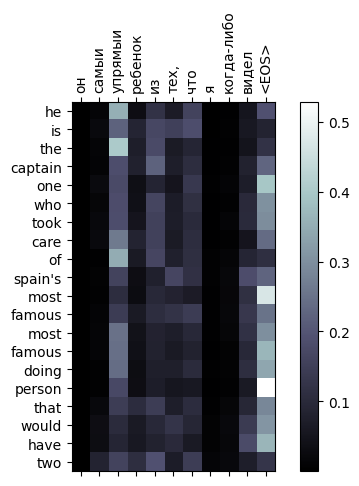

In [ ]:
evaluateAndShowAttention('он самыи упрямыи ребенок из тех, что я когда-либо видел', decoder)

input = он совершенно прав
output = he is quite right . <EOS>


<ipython-input-27-f52b6cb9e81c>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-27-f52b6cb9e81c>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


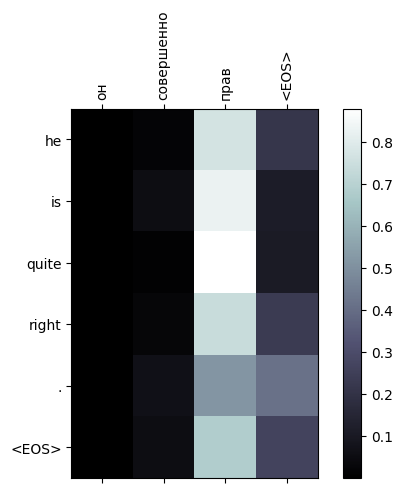

In [ ]:
evaluateAndShowAttention('он совершенно прав', decoder)

### Механизм внимания на основе скалярного произведения

In [ ]:
class MLPAttention(nn.Module):
    def __init__(self, hidden_size):
        super(MLPAttention, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2 * hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, query, keys):

        # Расширяем query до размеров keys
        query_expanded = query.expand(-1, keys.size(1), -1)

        # Конкатенируем query и keys
        concat = torch.cat((query_expanded, keys), dim=2)

        # Применяем MLP для получения scores
        scores = self.mlp(concat)
        scores = scores.squeeze(2).unsqueeze(1)

        # Применяем softmax для получения весов внимания
        weights = F.softmax(scores, dim=-1)

        # Вычисляем контекст как взвешенную сумму ключей
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderMLP(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderMLP, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = MLPAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))
        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)
        return output, hidden, attn_weights

Reading lines...
Read 496059 sentence pairs
Trimmed to 4414 sentence pairs
Counting words...
Counted words:
rus 3975
eng 2089
0m 13s (- 3m 29s) (5 6%) 2.1382
0m 27s (- 3m 15s) (10 12%) 1.1383
0m 41s (- 3m 0s) (15 18%) 0.7015
0m 55s (- 2m 46s) (20 25%) 0.4262
1m 10s (- 2m 34s) (25 31%) 0.2536
1m 23s (- 2m 19s) (30 37%) 0.1492
1m 37s (- 2m 5s) (35 43%) 0.0886
1m 51s (- 1m 51s) (40 50%) 0.0573
2m 6s (- 1m 38s) (45 56%) 0.0389
2m 20s (- 1m 24s) (50 62%) 0.0304
2m 34s (- 1m 10s) (55 68%) 0.0246
2m 48s (- 0m 56s) (60 75%) 0.0203
3m 2s (- 0m 42s) (65 81%) 0.0191
3m 16s (- 0m 28s) (70 87%) 0.0179
3m 30s (- 0m 14s) (75 93%) 0.0152
3m 45s (- 0m 0s) (80 100%) 0.0142


<Figure size 640x480 with 0 Axes>

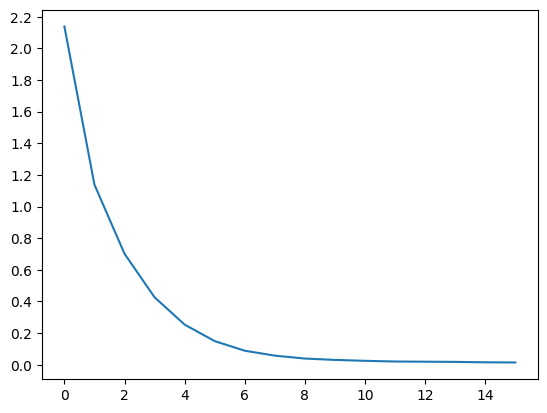

In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoderMLP = AttnDecoderMLP(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoderMLP, 80, print_every=5, plot_every=5)

#### Оценка модели

In [ ]:
encoder.eval()
decoderMLP.eval()
evaluateRandomly(encoder, decoderMLP)

#### Визуализация

In [ ]:
evaluateAndShowAttention('он самыи упрямыи ребенок из тех, что я когда-либо видел', decoderMLP)

In [ ]:
evaluateAndShowAttention('он совершенно прав', decoderMLP)

### На основе скалярного произведения

In [ ]:
class DotProductAttention(nn.Module):
    def __init__(self, hidden_size):
        super(DotProductAttention, self).__init__()
        # В dot-product attention нам не нужны дополнительные параметры, как в Bahdanau или MLP
        pass

    def forward(self, query, keys):

        # Вычисляем scores как скалярное произведение между query и keys
        scores = torch.bmm(query, keys.transpose(1, 2))  # (batch_size, 1, seq_len)

        # Применяем softmax для получения весов внимания
        weights = F.softmax(scores, dim=-1)

        # Вычисляем контекст как взвешенную сумму ключей
        context = torch.bmm(weights, keys)  # (batch_size, 1, hidden_size)

        return context, weights


class AttnDecoderDPA(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderDPA, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = DotProductAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))
        query = hidden.permute(1, 0, 2)  # (batch_size, 1, hidden_size)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)
        return output, hidden, attn_weights

In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoderDPA = AttnDecoderDPA(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoderDPA, 80, print_every=5, plot_every=5)

Reading lines...
Read 496059 sentence pairs
Trimmed to 4414 sentence pairs
Counting words...
Counted words:
rus 3975
eng 2089
0m 11s (- 2m 47s) (5 6%) 2.2247
0m 22s (- 2m 35s) (10 12%) 1.2756
0m 33s (- 2m 24s) (15 18%) 0.9081
0m 44s (- 2m 13s) (20 25%) 0.6697
0m 55s (- 2m 1s) (25 31%) 0.5023
1m 6s (- 1m 50s) (30 37%) 0.3783
1m 17s (- 1m 39s) (35 43%) 0.2859
1m 28s (- 1m 28s) (40 50%) 0.2133
1m 39s (- 1m 17s) (45 56%) 0.1586
1m 50s (- 1m 6s) (50 62%) 0.1183
2m 1s (- 0m 55s) (55 68%) 0.0896
2m 13s (- 0m 44s) (60 75%) 0.0687
2m 24s (- 0m 33s) (65 81%) 0.0561
2m 35s (- 0m 22s) (70 87%) 0.0432


#### Оценка модели

In [ ]:
encoder.eval()
decoderDPA.eval()
evaluateRandomly(encoder, decoderDPA)

#### Визуализация

In [ ]:
evaluateAndShowAttention('он самыи упрямыи ребенок из тех, что я когда-либо видел', decoderDPA)

In [ ]:
evaluateAndShowAttention('он совершенно прав', decoderDPA)